Code was slightly adapted from https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py

In [13]:
from keras.models import Sequential
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras import backend as K

import numpy as np
import h5py
from scipy.misc import imsave
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
%matplotlib inline

We now load the weights from the pretrained VGG16 down from keras (see above imports "from keras.applications.vgg16 import VGG16") and feed it into the built model. We set include_top=False, since we do not want the fc part of VGG.

In [3]:
model = VGG16(weights='imagenet', include_top=False)

In [14]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, None, None, 64 1792        input_2[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, None, None, 64 36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, None, None, 64 0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [15]:
# this is the placeholder for the input images
input_img = model.input

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

# dimensions of the generated pictures for each filter.
img_width = 128
img_height = 128


**Here you can select the layer and the filter**

In [160]:
# define in which layer and therein which feature map 
# you want to find the image pattern giving rise to maximal activation

layer_name = 'block5_conv2'  # define block and layer 
filter_index = 410  # define the number of the feature map for which you want to optimize

In [161]:
# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output

# the objective for optimization is the mean-activation in the respective neuron
# we want to maximize this mean activation -> we maximize the "loss" which is here a "reward"
loss = K.mean(layer_output[:, :, :, filter_index])  # in tf the filter_index is last argument

# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient so thtat is stays in reasonable range
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

In [162]:
# we start from a gray image with some noise
input_img_data = np.random.random((1, img_width, img_height,3)) * 20 + 128.
input_img_data.shape

(1, 128, 128, 3)

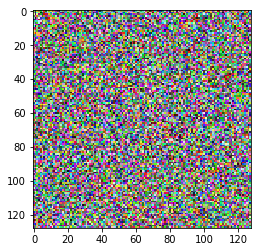

In [163]:
plt.imshow(input_img_data[0])

In [164]:
# run gradient ascent for 20 steps
# step size for gradient ascent
step = 1.
for i in range(20):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

In [165]:
input_img_data.shape

(1, 128, 128, 3)

In [166]:
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1,2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [167]:
img = input_img_data[0]
img = deprocess_image(img)
img.shape

(128, 128, 3)

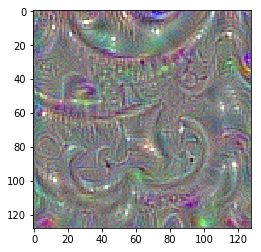

In [168]:
plt.imshow(img)